# Analysis of animal re-identification datasets

This notebook shows some basic characteristics of the datasets extracted from the dataframes or metadata.

In [1]:
import sys
sys.path.append('..')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wildlife_datasets import datasets, loader

root_dataset = '/data/wildlife_datasets/data'
root_dataframe = '/data/wildlife_datasets/dataframes'

datasets_ignore = ['SeaTurtleIDHeads']
dataset_names = [dataset_name for dataset_name in datasets.names_all]
dataset_names = [dataset_name for dataset_name in datasets.names_all 
                    if 'Segmented' not in dataset_name.__name__
                        and dataset_name.__name__ not in datasets_ignore
                ]

ds = loader.load_datasets(dataset_names, root_dataset, root_dataframe)

Resolving data files:   0%|          | 0/46 [00:00<?, ?it/s]

The number of published datasets steadily increases throughout the years.

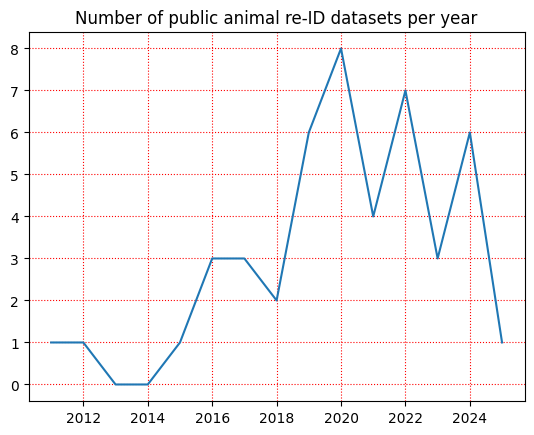

In [2]:
years = np.array([d.summary['year'] for d in ds])
years_range = range(min(years), max(years)+1)
counts = [sum(year == years) for year in years_range]

plt.plot(years_range, counts)
plt.title('Number of public animal re-ID datasets per year');
plt.grid(which='major', color='r', linestyle=':')

The next code shows a summary of each dataset with the publication year, number of images and individuals and other information.

In [3]:
def number_individuals(df):
    identities = df['identity'].unique()
    if 'unknown' in list(identities):
        return len(identities)-1
    else:
        return len(identities)

def number_images(df):
    return sum(df['identity'] != 'unknown')

def number_species(df):
    return df['species'].count() if 'species' in df.columns else 1

def create_dict(i):
    return {
        'species': i.summary['animals_simple'],
        'year': i.summary['year'],
        '$n_{\\rm img}$': number_images(i.df),
        '$n_{\\rm ind}$': number_individuals(i.df),
        'span': i.summary['span'],
        'source': 'video' if i.summary['from_video'] else 'photo',
        'pose': i.summary['pose'],
        'timestamp': 'date' in i.df.columns,
        'wild': i.summary['wild'],
        'more species': number_species(i.df) > 1,
        'size (MB)': int(i.summary['size'])
    }

names = [d.display_name() for d in ds]
df = pd.DataFrame([create_dict(d) for d in ds], index=names)

df_print = df.copy()
df_print.replace(True, "\u2714", inplace=True)
df_print.replace(False, "\u2716", inplace=True)
df_print

,species,year,$n_{\rm img}$,$n_{\rm ind}$,span,source,pose,timestamp,wild,more species,size (MB)
AAUZebraFish,fish,2020,6672,6,1 day,video,double,✖,✖,✖,12093
AerialCattle2017,cows,2017,46340,23,1 day,video,single,✖,✖,✖,724
AmvrakikosTurtles,sea turtles,2024,200,50,4.4 years,photo,double,✔,✔,✖,1870
ATRW,tigers,2019,5415,182,short,video,double,✖,✖,✖,1760
BelugaID,whales,2022,8559,788,2.1 years,photo,single,✔,✔,✔,590
BirdIndividualID,birds,2019,51934,50,15 days,photo,single,✔,✖,✔,70656
BristolGorillas2020,gorillas,2020,5594,7,short,video,single,✖,✖,✖,15600
CatIndividualImages,cats,2020,13021,509,short,photo,multiple,✖,✖,✖,11000
Chicks4FreeID,chickens,2024,1146,50,short,photo,single,✖,✖,✖,1401
CowDataset,cows,2021,1485,13,short,photo,double,✔,✖,✖,4150


In [4]:
def convert_latex(df, ds, add_citations=True):    
    df = df.copy()
    if add_citations:
        cites = [r' \cite{' + d.summary['cite'] + '}' for d in ds]
        df.insert(loc=0, column = 'name', value=df.index+cites)
    else:
        df.insert(loc=0, column = 'name', value=df.index)
    df.replace(True, r'\cmark', inplace=True)
    df.replace(False, r'\xmark', inplace=True)
    return df.to_latex(index=False, escape=False, float_format="%.0f")

print(convert_latex(df, ds))

\begin{tabular}{llrrrllllllr}
\toprule
name & species & year & $n_{\rm img}$ & $n_{\rm ind}$ & span & source & pose & timestamp & wild & more species & size (MB) \\
\midrule
AAUZebraFish \cite{bruslund2020re} & fish & 2020 & 6672 & 6 & 1 day & video & double & \xmark & \xmark & \xmark & 12093 \\
AerialCattle2017 \cite{andrew2017visual} & cows & 2017 & 46340 & 23 & 1 day & video & single & \xmark & \xmark & \xmark & 724 \\
AmvrakikosTurtles \cite{adam2024exploiting} & sea turtles & 2024 & 200 & 50 & 4.4 years & photo & double & \cmark & \cmark & \xmark & 1870 \\
ATRW \cite{li2019atrw} & tigers & 2019 & 5415 & 182 & short & video & double & \xmark & \xmark & \xmark & 1760 \\
BelugaID \cite{belugaid} & whales & 2022 & 8559 & 788 & 2.1 years & photo & single & \cmark & \cmark & \cmark & 590 \\
BirdIndividualID \cite{ferreira2020deep} & birds & 2019 & 51934 & 50 & 15 days & photo & single & \cmark & \xmark & \cmark & 70656 \\
BristolGorillas2020 \cite{brookes2020dataset} & gorillas & 2020 &